In [23]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize, downscale_local_mean
import math
import os
import numpy as np

import seaborn as sns
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import pingouin as pg
import scikit_posthocs as sp

import sys
sys.path.append("/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *

import numpy as np
import matplotlib.pyplot as plt

In [24]:
from PIL import Image, ImageFilter
def get_edge(img):
    #define the vertical filter
    vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

    #define the horizontal filter
    horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

    #get the dimensions of the image
    n,m = img.shape

    #initialize the edges image
    edges_img = img.copy()

    #loop over all pixels in the image
    for row in range(3, n-2):
        for col in range(3, m-2):

            #create little local 3x3 box
            local_pixels = img[row-1:row+2, col-1:col+2]

            #apply the vertical filter
            vertical_transformed_pixels = vertical_filter*local_pixels
            #remap the vertical score
            vertical_score = vertical_transformed_pixels.sum()/4

            #apply the horizontal filter
            horizontal_transformed_pixels = horizontal_filter*local_pixels
            #remap the horizontal score
            horizontal_score = horizontal_transformed_pixels.sum()/4

            #combine the horizontal and vertical scores into a total edge score
            edge_score = (vertical_score**2 + horizontal_score**2)**.5

            #insert this edge score into the edges image
            edges_img[row, col] = edge_score*2

    #remap the values in the 0-1 range in case they went out of bounds
    edges_img = edges_img/edges_img.max()
    edges_img[edges_img ==0] = 'nan'
    edges_img[edges_img >0] = 1
    return edges_img

In [25]:
# Pick volunteer
vv = 4

In [26]:
volunteers=[1,2,3,4,5,7,8,9,10,11]


# For each volunteer 
M0_mag = np.zeros((128,128,6,4,5,8))
M1_mag = np.zeros((128,128,6,4,5,8))
M2_mag = np.zeros((128,128,6,4,5,8))

M0_phs = np.zeros((128,128,6,4,5,8))
M1_phs = np.zeros((128,128,6,4,5,8))
M2_phs = np.zeros((128,128,6,4,5,8))


volunteer = str(volunteers[vv])
print(volunteer, end = ' ')
inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Brain/V00' + volunteer + '/3_DWI/'
name = inpath.split('/')
namejoin = '/'.join(name[:-1])

num = 0
for num in range(3):
    nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
    bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
    bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]
    mask_files   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
    

    nii_files.sort()
    bval_files.sort()
    bvec_files.sort()
    mask_files.sort()
    
    data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
    bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
    bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))
    mask,header =  nrrd.read(os.path.join(inpath, mask_files[num]))
    
    mask = mask.astype('float')
    mask[mask==0] = np.nan
    
    
    data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)
    
    ims = np.stack((data1[:,:,:,:,:5],data1[:,:,:,:,5:10],data1[:,:,:,:,10:15],
                        data1[:,:,:,:,15:20],data1[:,:,:,:,20:25],data1[:,:,:,:,25:30],
                        data1[:,:,:,:,30:35],data1[:,:,:,:,35:40]),axis = -1)  
        
    
    mag = abs(ims)
    phs = np.angle(ims)
    mask_rep = np.tile(mask[:,:,:,np.newaxis,np.newaxis,np.newaxis],(1,1,1,ims.shape[3],ims.shape[4],ims.shape[5]))
    mask_rep[mask_rep ==0] = np.nan
    
    if num == 0:
        M0_mag[:,:,:,:,:,:] = mag #* mask_rep
        M0_phs[:,:,:,:,:,:,] = phs #*mask_rep
        M0_mask = mask_rep #*mask_rep
        
    if num == 1:
        M1_mag[:,:,:,:,:,:,] = mag #* mask_rep
        M1_phs[:,:,:,:,:,:] = phs #*mask_rep
        M1_mask = mask_rep #*mask_rep
        
    if num == 2:
        M2_mag[:,:,:,:,:,:] = mag #* mask_rep
        M2_phs[:,:,:,:,:,:] = phs #*mask_rep
        M2_mask = mask_rep #*mask_rep

# NOT divide by the average 
M0_adj = (np.exp(1j*M0_phs))/np.nanmean(np.exp(1j*M0_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
M1_adj = (np.exp(1j*M1_phs))/np.nanmean(np.exp(1j*M1_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
M2_adj = (np.exp(1j*M2_phs))/np.nanmean(np.exp(1j*M2_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:] 

M0_diff = np.angle(M0_adj / np.tile(np.nanmean(M0_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))
M1_diff = np.angle(M1_adj / np.tile(np.nanmean(M1_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))
M2_diff = np.angle(M2_adj / np.tile(np.nanmean(M2_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))

M0_std = np.sqrt(np.sum(M0_diff**2,axis = -2)/5)
M1_std = np.sqrt(np.sum(M1_diff**2,axis = -2)/5)
M2_std = np.sqrt(np.sum(M2_diff**2,axis = -2)/5)

5 

In [27]:
diffusion = -1 # diffusion direction [0, X [1], Y[2], Z[3]]
sl = 3 #slice [Base [0], Mid[0], Apex[2]]
rep = 1

TD 1 Volunteer 4 sl 3


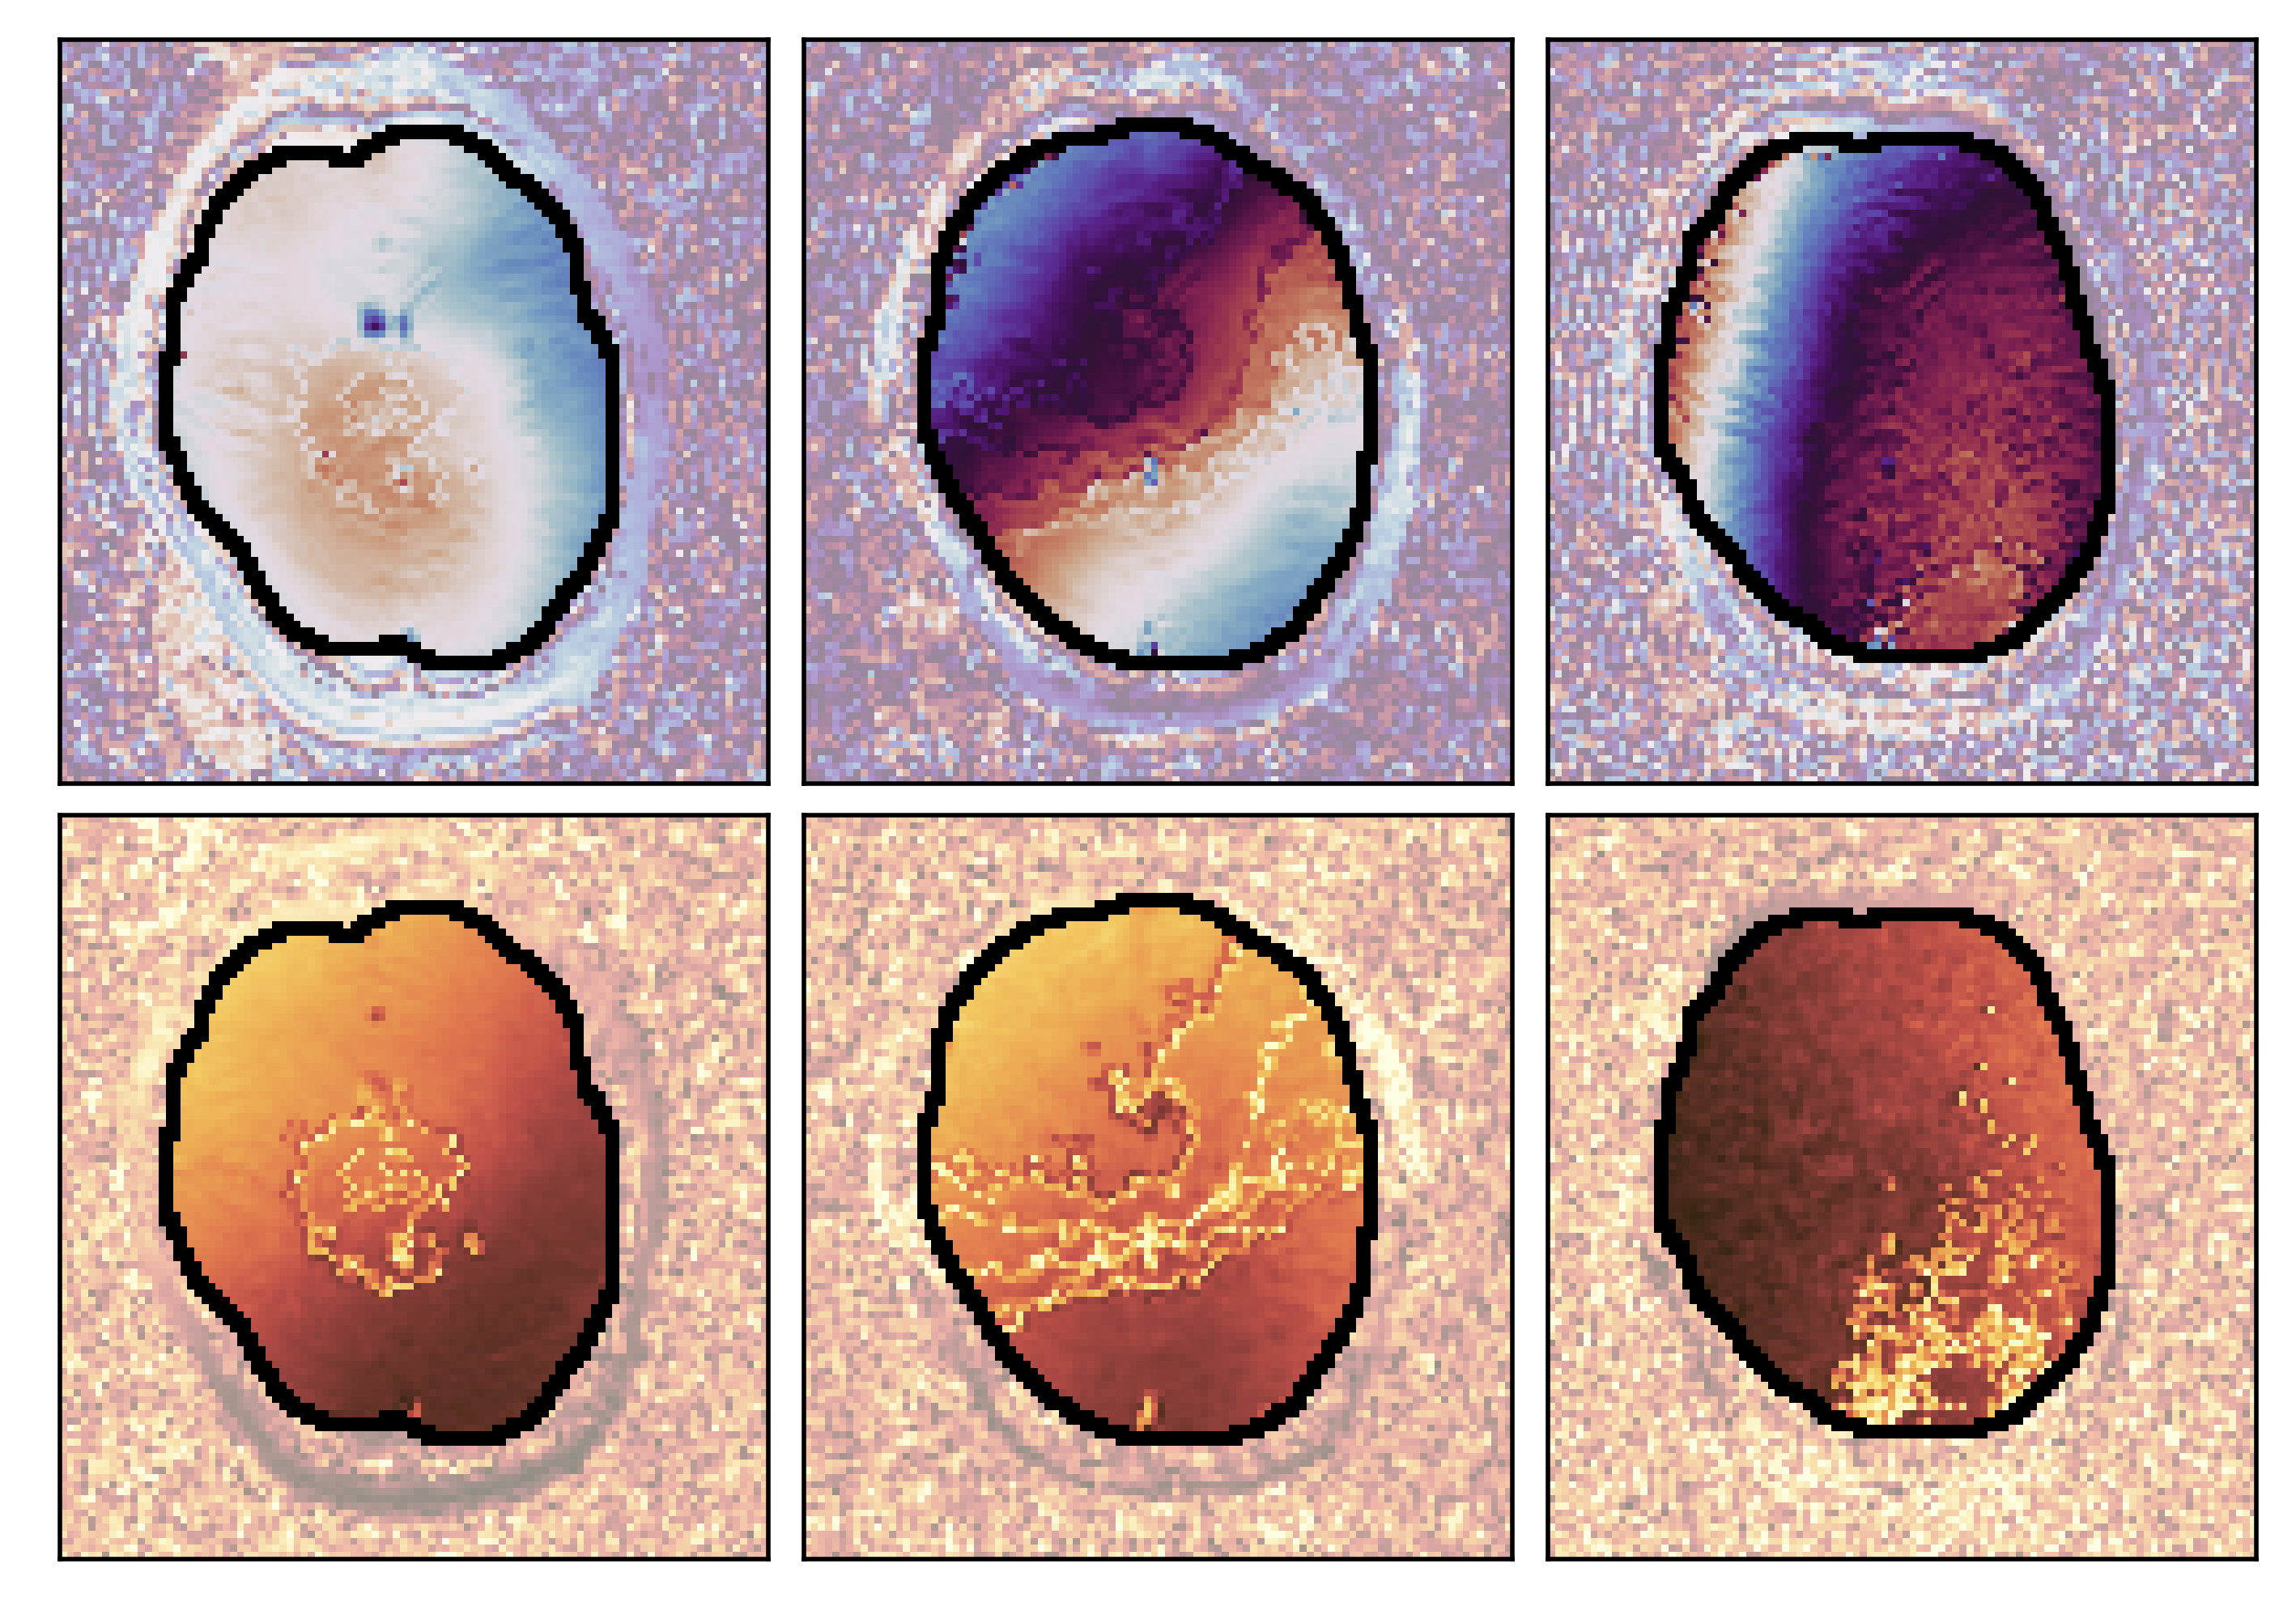

TD 4 Volunteer 4 sl 3


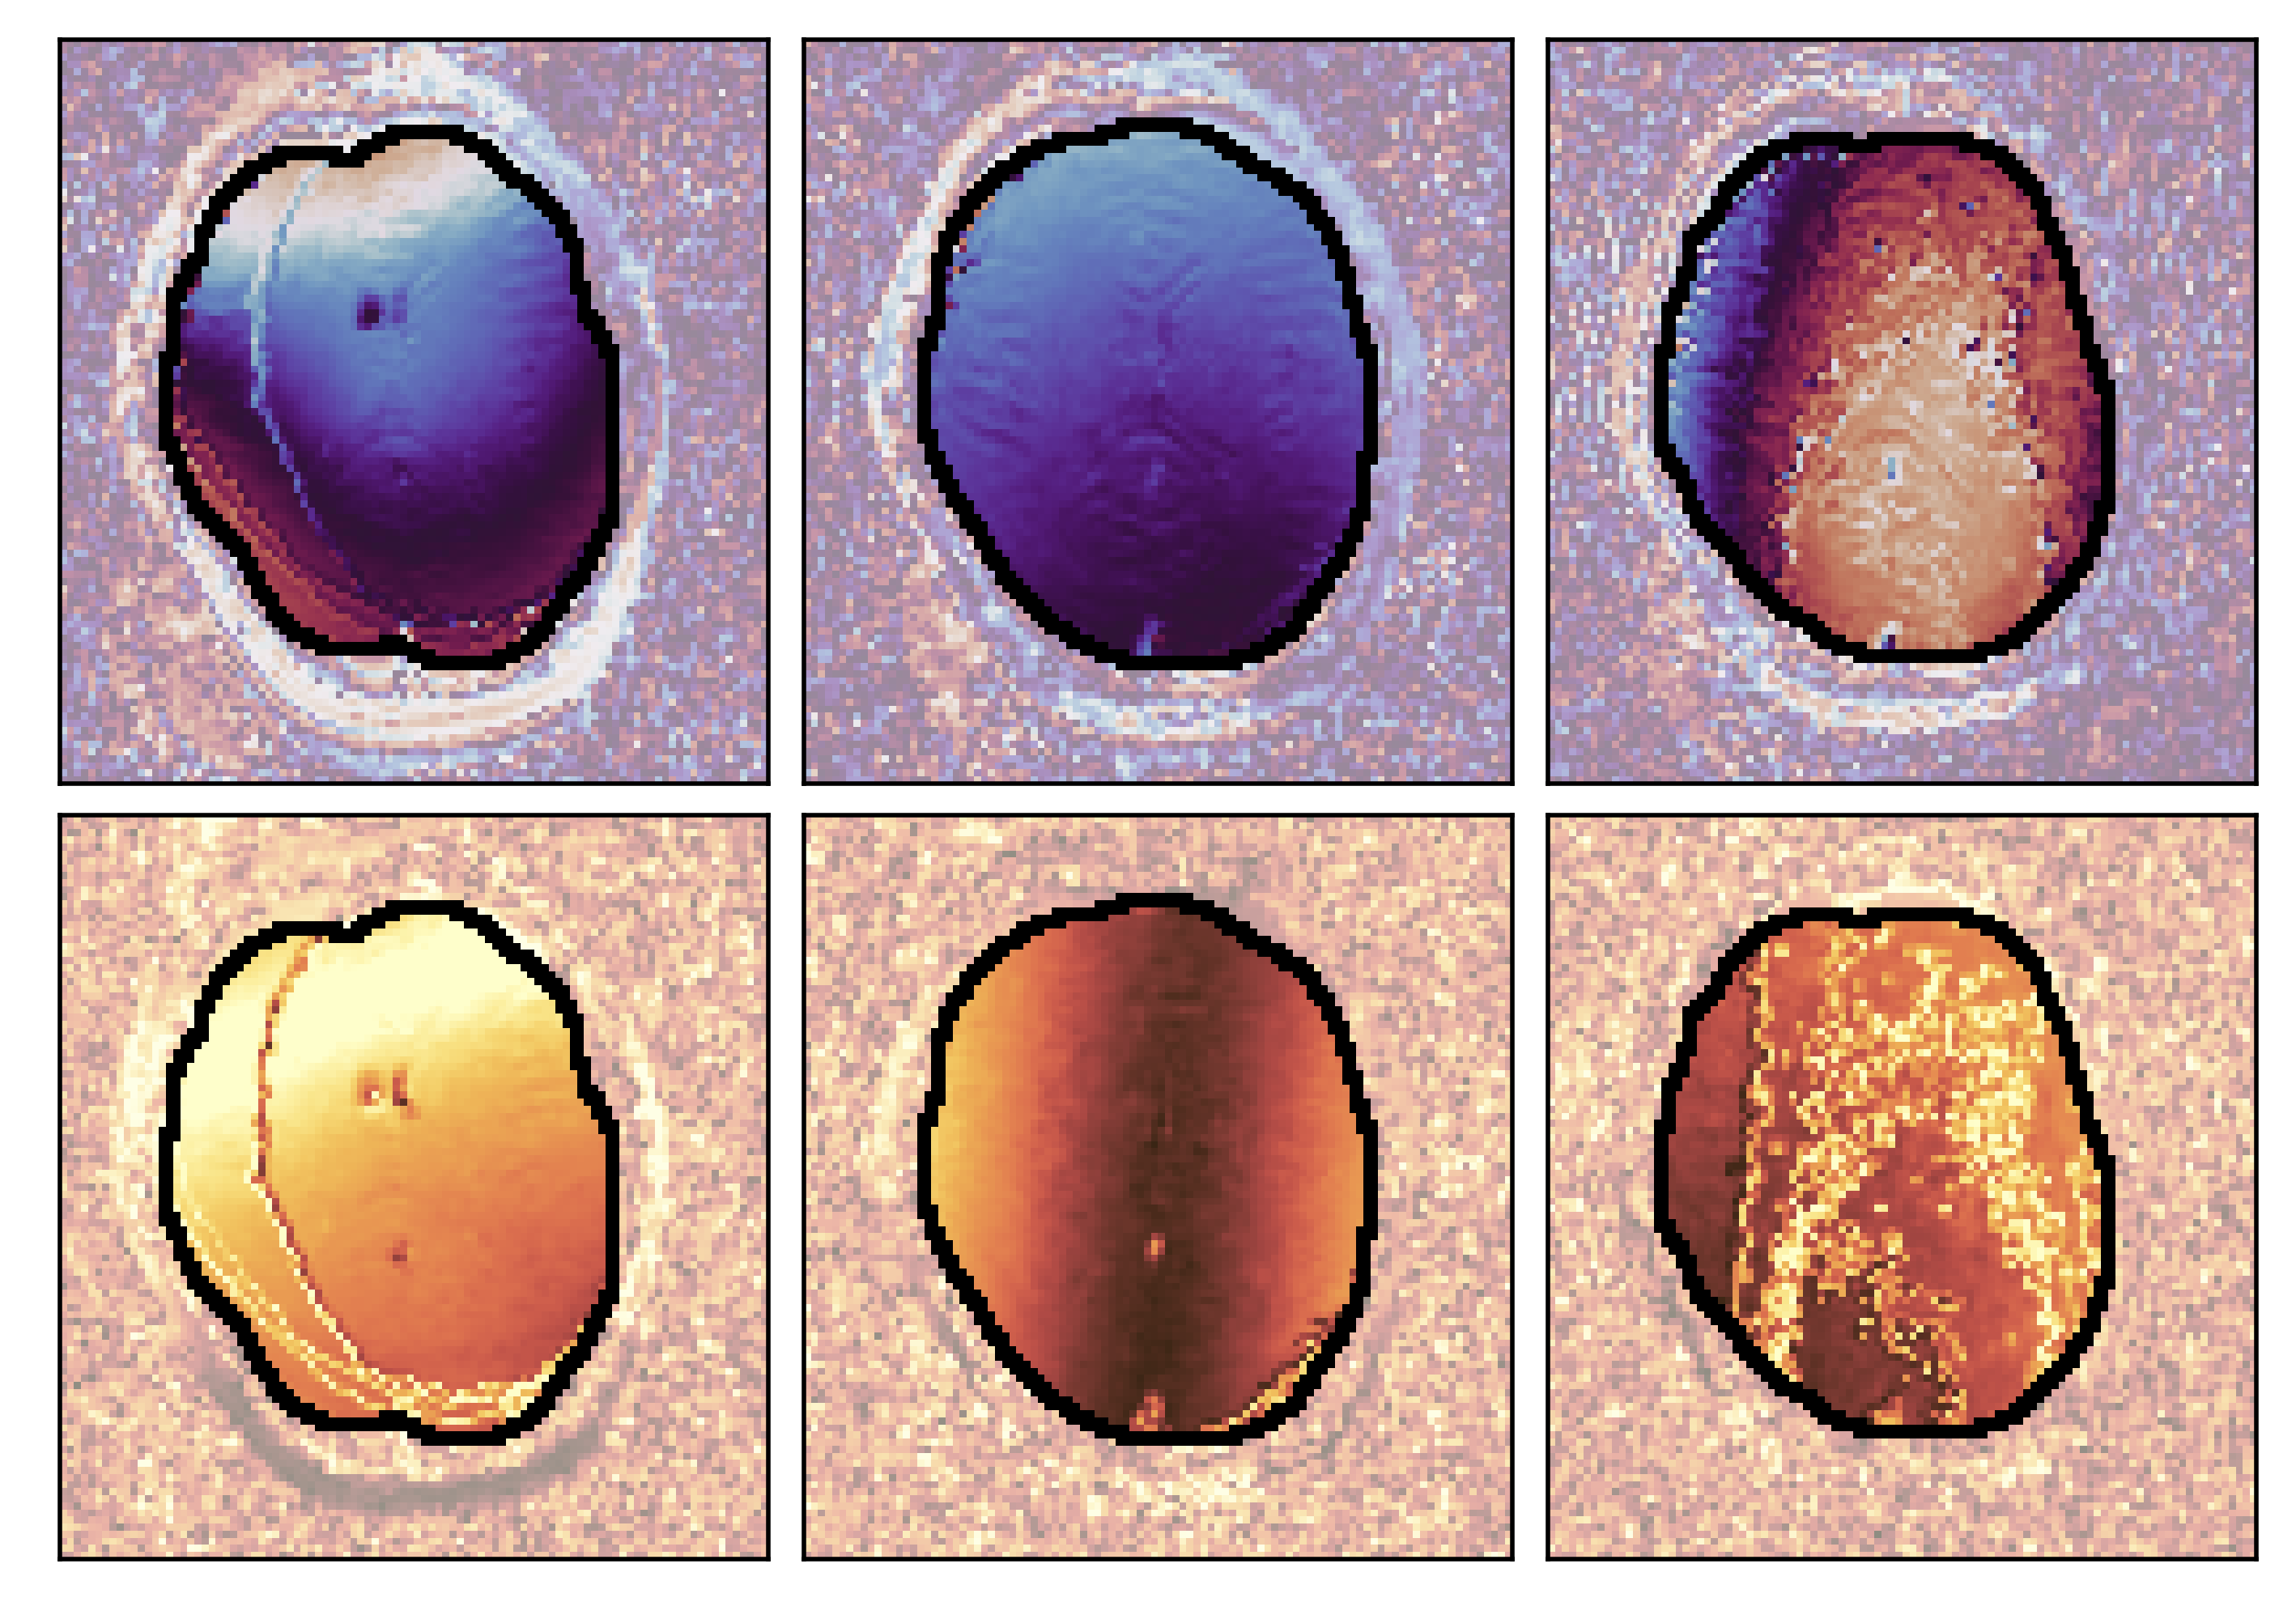

TD 7 Volunteer 4 sl 3


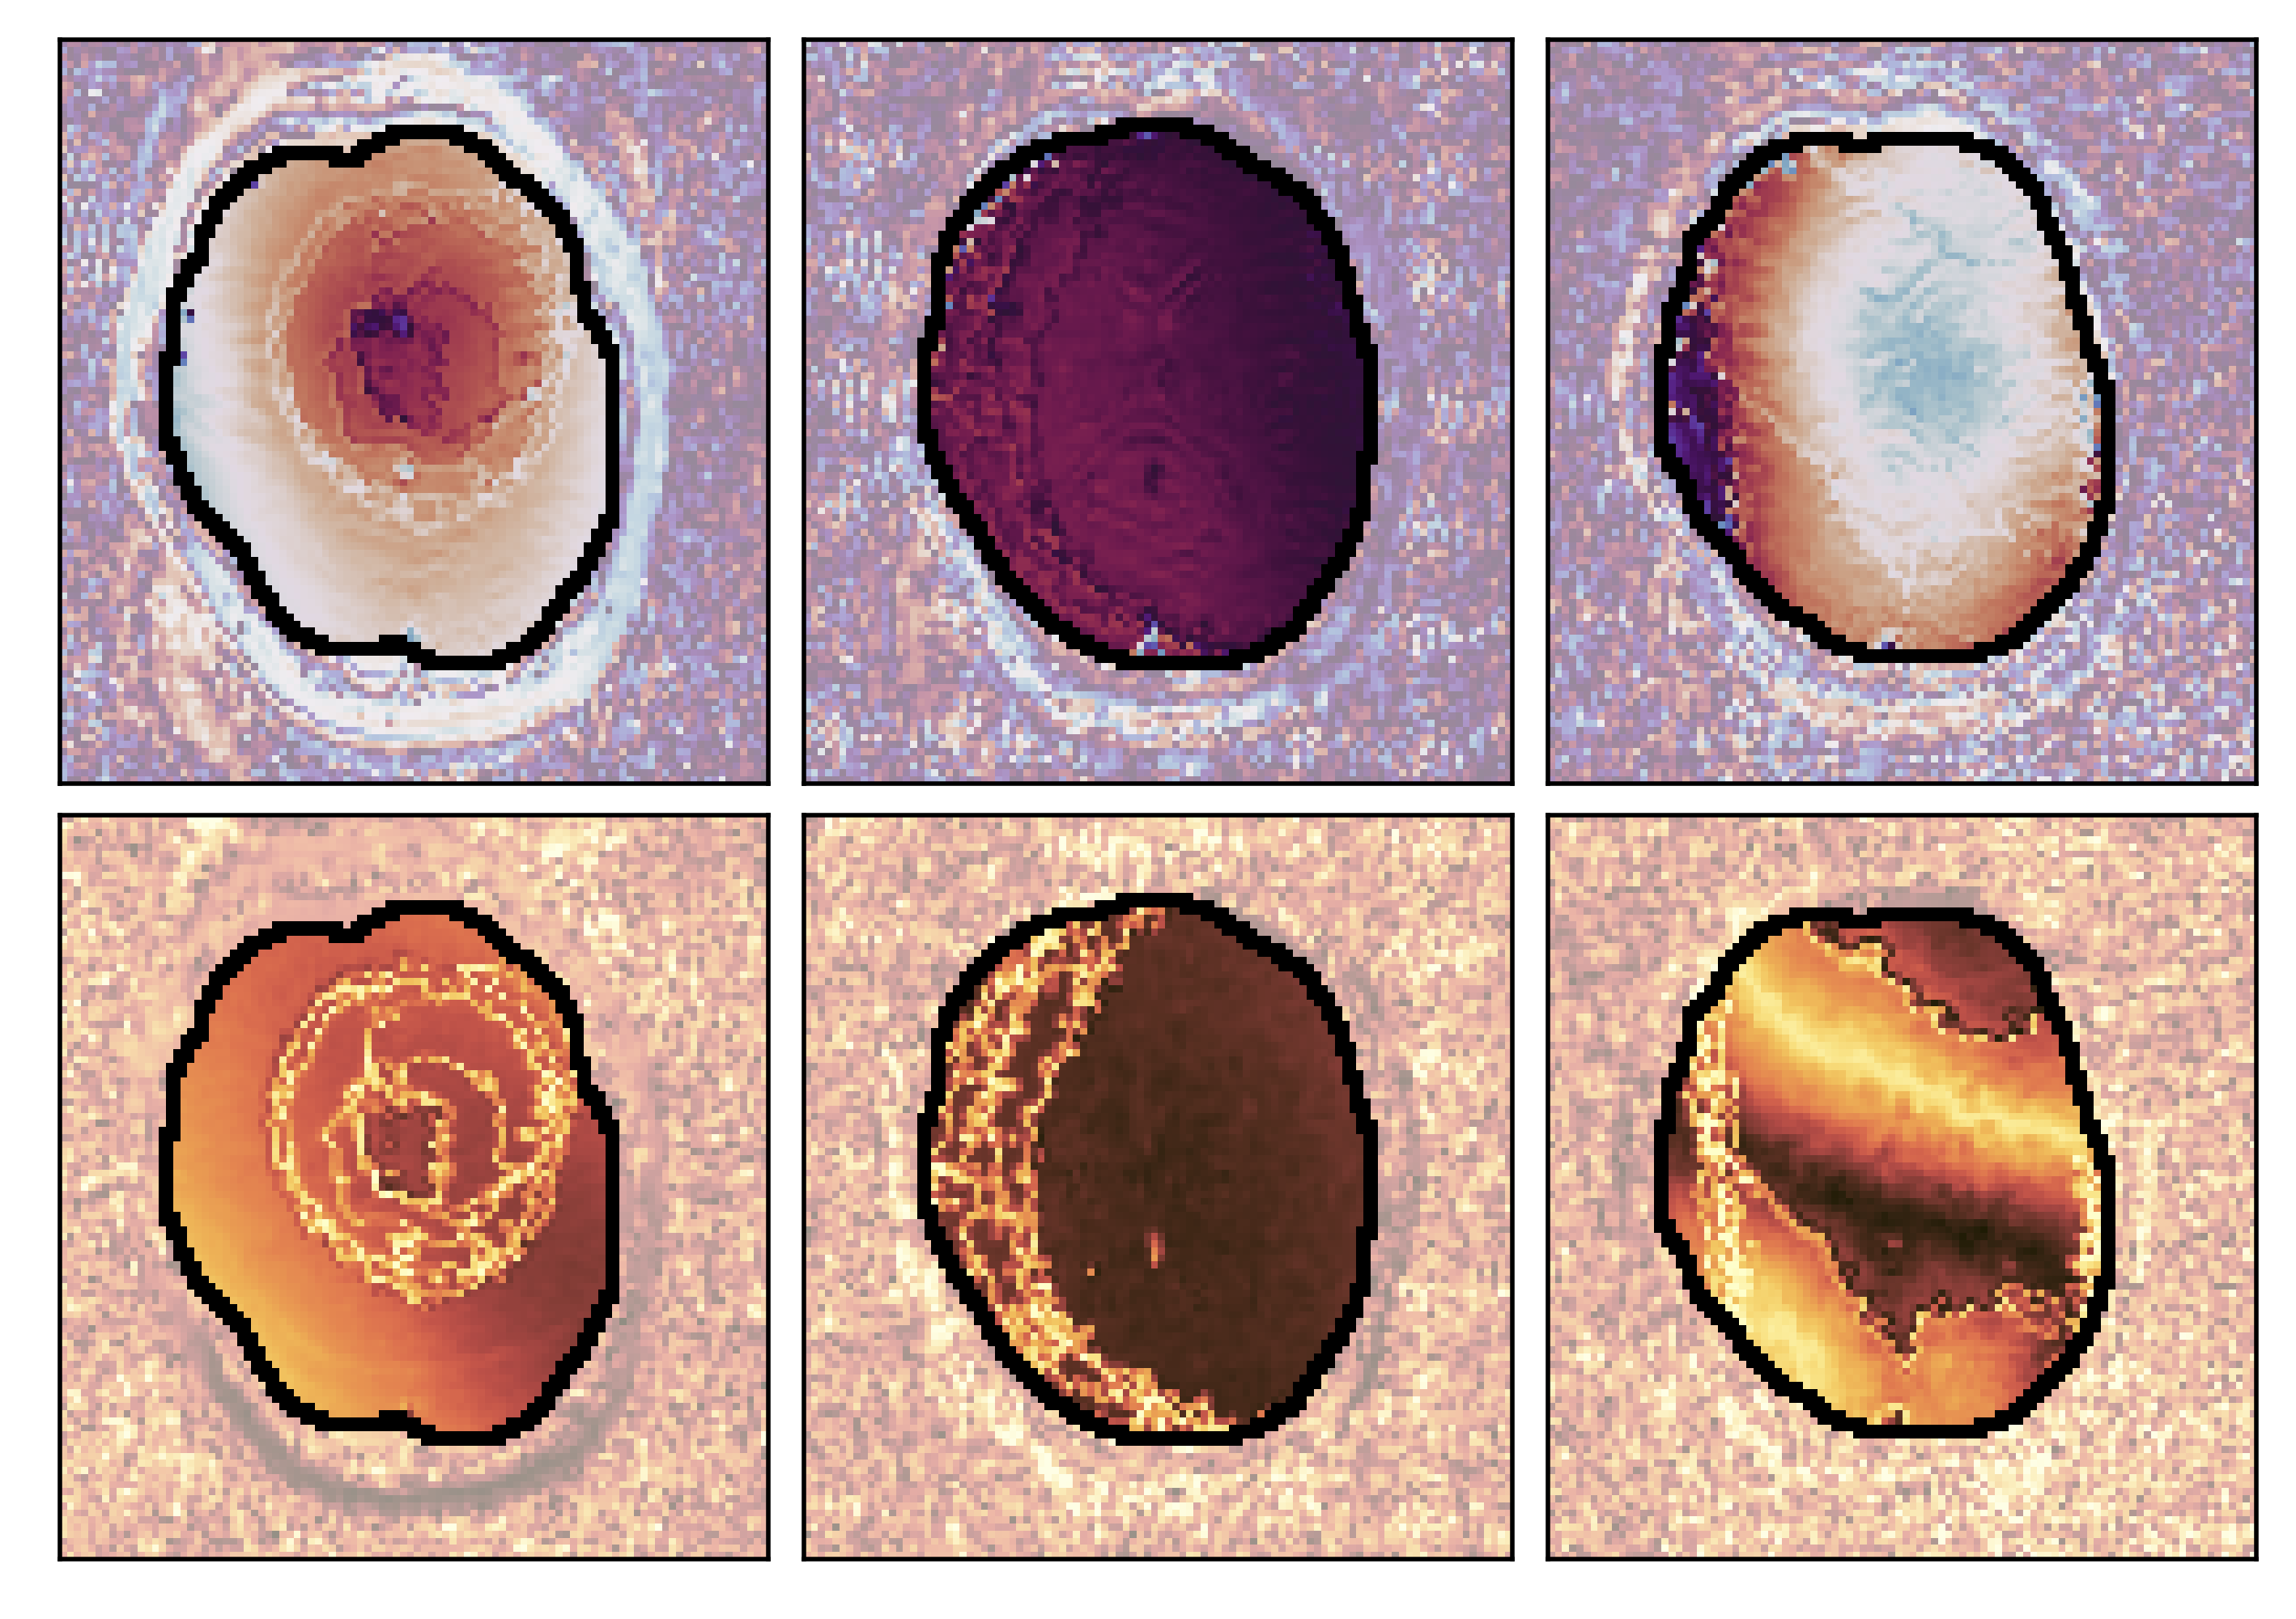

In [28]:
# Horizontal Fig 
for td in  [1,4,7]:
    print('TD',td, 'Volunteer',vv,'sl',sl)
    fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(7,5), dpi=500)

    w1 = 15
    w2 = 120
    l1= 15
    l2 = 115



    color = 'twilight'
    ######### Average Phase
    phs_m0 = np.angle(np.nanmean(M0_adj,axis = -2))
    phs_m1 = np.angle(np.nanmean(M1_adj,axis = -2))
    phs_m2 = np.angle(np.nanmean(M2_adj,axis = -2))
    axes[0,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,td],vmin = -math.pi,vmax = math.pi,cmap = color,alpha = 0.5,interpolation = 'nearest')
    axes[0,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,td,],vmin = -math.pi,vmax = math.pi,cmap = color,alpha = 0.5,interpolation = 'nearest')
    im2=axes[0,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,td],vmin = -math.pi,vmax = math.pi,cmap = color,alpha = 0.5,interpolation = 'nearest')

    phs_m0 = np.angle(np.nanmean(M0_adj,axis = -2))[:,:,:,:,np.newaxis,:] * M0_mask
    phs_m1 = np.angle(np.nanmean(M1_adj,axis = -2))[:,:,:,:,np.newaxis,:] * M1_mask
    phs_m2 = np.angle(np.nanmean(M2_adj,axis = -2))[:,:,:,:,np.newaxis,:] * M2_mask
    axes[0,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = -math.pi,vmax = math.pi,cmap = color,interpolation = 'nearest')
    axes[0,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = -math.pi,vmax = math.pi,cmap = color,interpolation = 'nearest')
    im4=axes[0,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = -math.pi,vmax = math.pi,cmap = color,interpolation = 'nearest')
    axes[0,0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[0,1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[0,2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')


    """
    ######### Difference from Mean Phase
    phs_m0 = (M0_diff) #* M0_mask[:,:,:,diffusion,0,:]
    phs_m1 = (M1_diff) #* M1_mask[:,:,:,diffusion,0,:]
    phs_m2 = (M2_diff) #* M2_mask[:,:,:,diffusion,0,:] 
    axes[2,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = -math.pi,vmax = math.pi,cmap = cm.romaO,alpha = 0.5,interpolation = 'nearest')
    axes[2,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,rep,td,],vmin = -math.pi,vmax = math.pi,cmap = cm.romaO,alpha = 0.5,interpolation = 'nearest')
    im2=axes[2,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = -math.pi,vmax = math.pi,cmap = cm.romaO,alpha = 0.5,interpolation = 'nearest')

    phs_m0 = (M0_diff) * M0_mask
    phs_m1 = (M1_diff) * M1_mask
    phs_m2 = (M2_diff) * M2_mask
    axes[2,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = -math.pi,vmax = math.pi,cmap = cm.romaO,interpolation = 'nearest')
    axes[2,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = -math.pi,vmax = math.pi,cmap = cm.romaO,interpolation = 'nearest')
    im4=axes[2,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,rep,td],vmin = -math.pi,vmax = math.pi,cmap = cm.romaO,interpolation = 'nearest')
    axes[2,0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[2,1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[2,2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')

    """
    color = cm.lajolla_r
    ######### STandard Deviation 
    phs_m0 = (M0_std) #* M0_mask[:,:,:,diffusion,0,:]
    phs_m1 = (M1_std) #* M1_mask[:,:,:,diffusion,0,:]
    phs_m2 = (M2_std) #* M2_mask[:,:,:,diffusion,0,:] 
    axes[1,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap =color,alpha = 0.5,interpolation = 'nearest')
    axes[1,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,td,],vmin = 0,vmax = math.pi/2,cmap = color,alpha = 0.5,interpolation = 'nearest')
    im2=axes[1,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap = color,alpha = 0.5,interpolation = 'nearest')

    phs_m0 = (M0_std[:,:,:,:,np.newaxis,:]) * M0_mask
    phs_m1 = (M1_std[:,:,:,:,np.newaxis,:]) * M1_mask
    phs_m2 = (M2_std[:,:,:,:,np.newaxis,:]) * M2_mask
    axes[1,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    axes[1,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    im4=axes[1,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    axes[1,0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[1,1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[1,2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')


    
 


    for m in range(2):
        for j in range(3):
            axes[m, j].get_xaxis().set_ticks([])
            axes[m, j].get_yaxis().set_ticks([])

    plt.subplots_adjust(wspace=0.05, hspace=0.03)   
    plt.show()

In [29]:
# Load in Spatial Gradients

volunteers=[1,2,3,4,5,7,8,9,10,11]
slope_m0 = np.zeros((128, 128, 6, 4, 5, 8, 10))
slope_m1 = np.zeros((128, 128, 6, 4, 5, 8, 10))
slope_m2 = np.zeros((128, 128, 6, 4, 5, 8, 10))

for vv in range(10):
    volunteer = str(volunteers[vv])
    inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Brain/V00' + volunteer + '/3_DWI/'
    savename = os.path.join(inpath,'M0_slope.npy')
    slope_m0[:,:,:,:,:,:,vv] = np.load(savename)

    savename = os.path.join(inpath,'M1_slope.npy')
    slope_m1[:,:,:,:,:,:,vv] = np.load(savename)
    
    savename = os.path.join(inpath,'M2_slope.npy')
    slope_m2[:,:,:,:,:,:,vv] = np.load(savename)
    

In [30]:
M0_diff.dtype

dtype('float64')

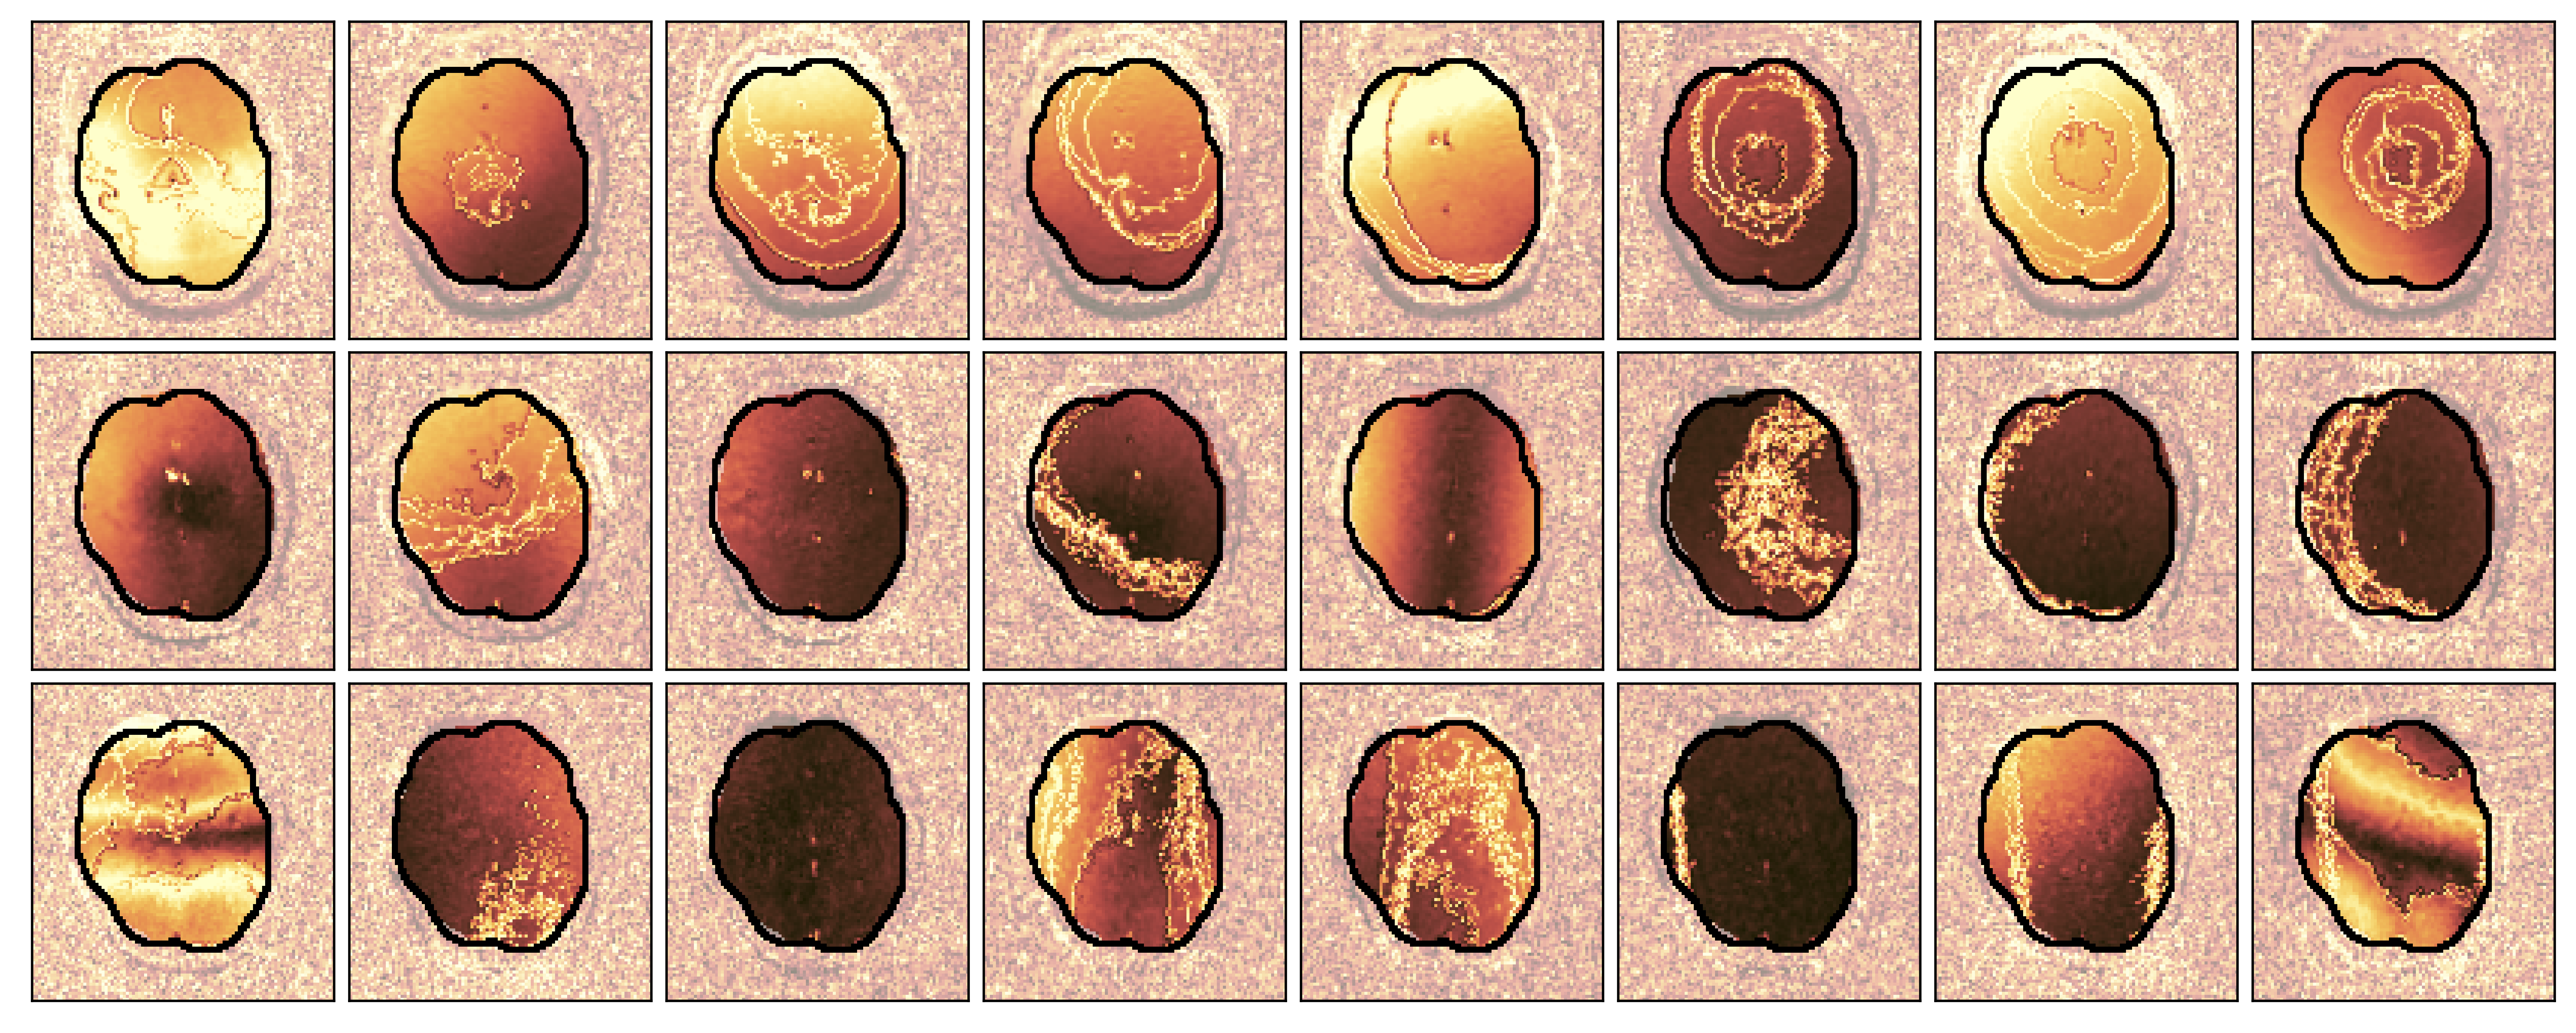

In [31]:
# Horizontal Fig 
#print('TD',td, 'Volunteer',vv,'sl',sl)
sl = 3
diffusion = -1

w1 = 15
w2 = 120
l1= 15
l2 = 115
color = cm.lajolla_r

fig, axes = plt.subplots(nrows=3, ncols=8,figsize=(15,6), dpi=500)
for td in  range(8):
    ######### STandard Deviation 
    phs_m0 = (M0_std) #* M0_mask[:,:,:,diffusion,0,:]
    axes[0,td].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap =color,alpha = 0.5,interpolation = 'nearest')
    phs_m0 = (M0_std[:,:,:,:,np.newaxis,:]) * M0_mask
    axes[0,td].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    axes[0,td].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')


for td in  range(8):
    ######### STandard Deviation 
    phs_m0 = (M1_std) #* M0_mask[:,:,:,diffusion,0,:]
    axes[1,td].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap =color,alpha = 0.5,interpolation = 'nearest')
    phs_m0 = (M1_std[:,:,:,:,np.newaxis,:]) * M1_mask
    axes[1,td].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    axes[1,td].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')

for td in  range(8):
    ######### STandard Deviation 
    phs_m0 = (M2_std) #* M0_mask[:,:,:,diffusion,0,:]
    axes[2,td].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap =color,alpha = 0.5,interpolation = 'nearest')
    phs_m0 = (M2_std[:,:,:,:,np.newaxis,:]) * M2_mask
    axes[2,td].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    axes[2,td].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')



for m in range(8):
    for jj in range(3):
        axes[jj,m].get_xaxis().set_ticks([])
        axes[jj,m].get_yaxis().set_ticks([])

plt.subplots_adjust(wspace=0.05, hspace=0.03)   
plt.show()

TD 1 Volunteer 9 sl 3


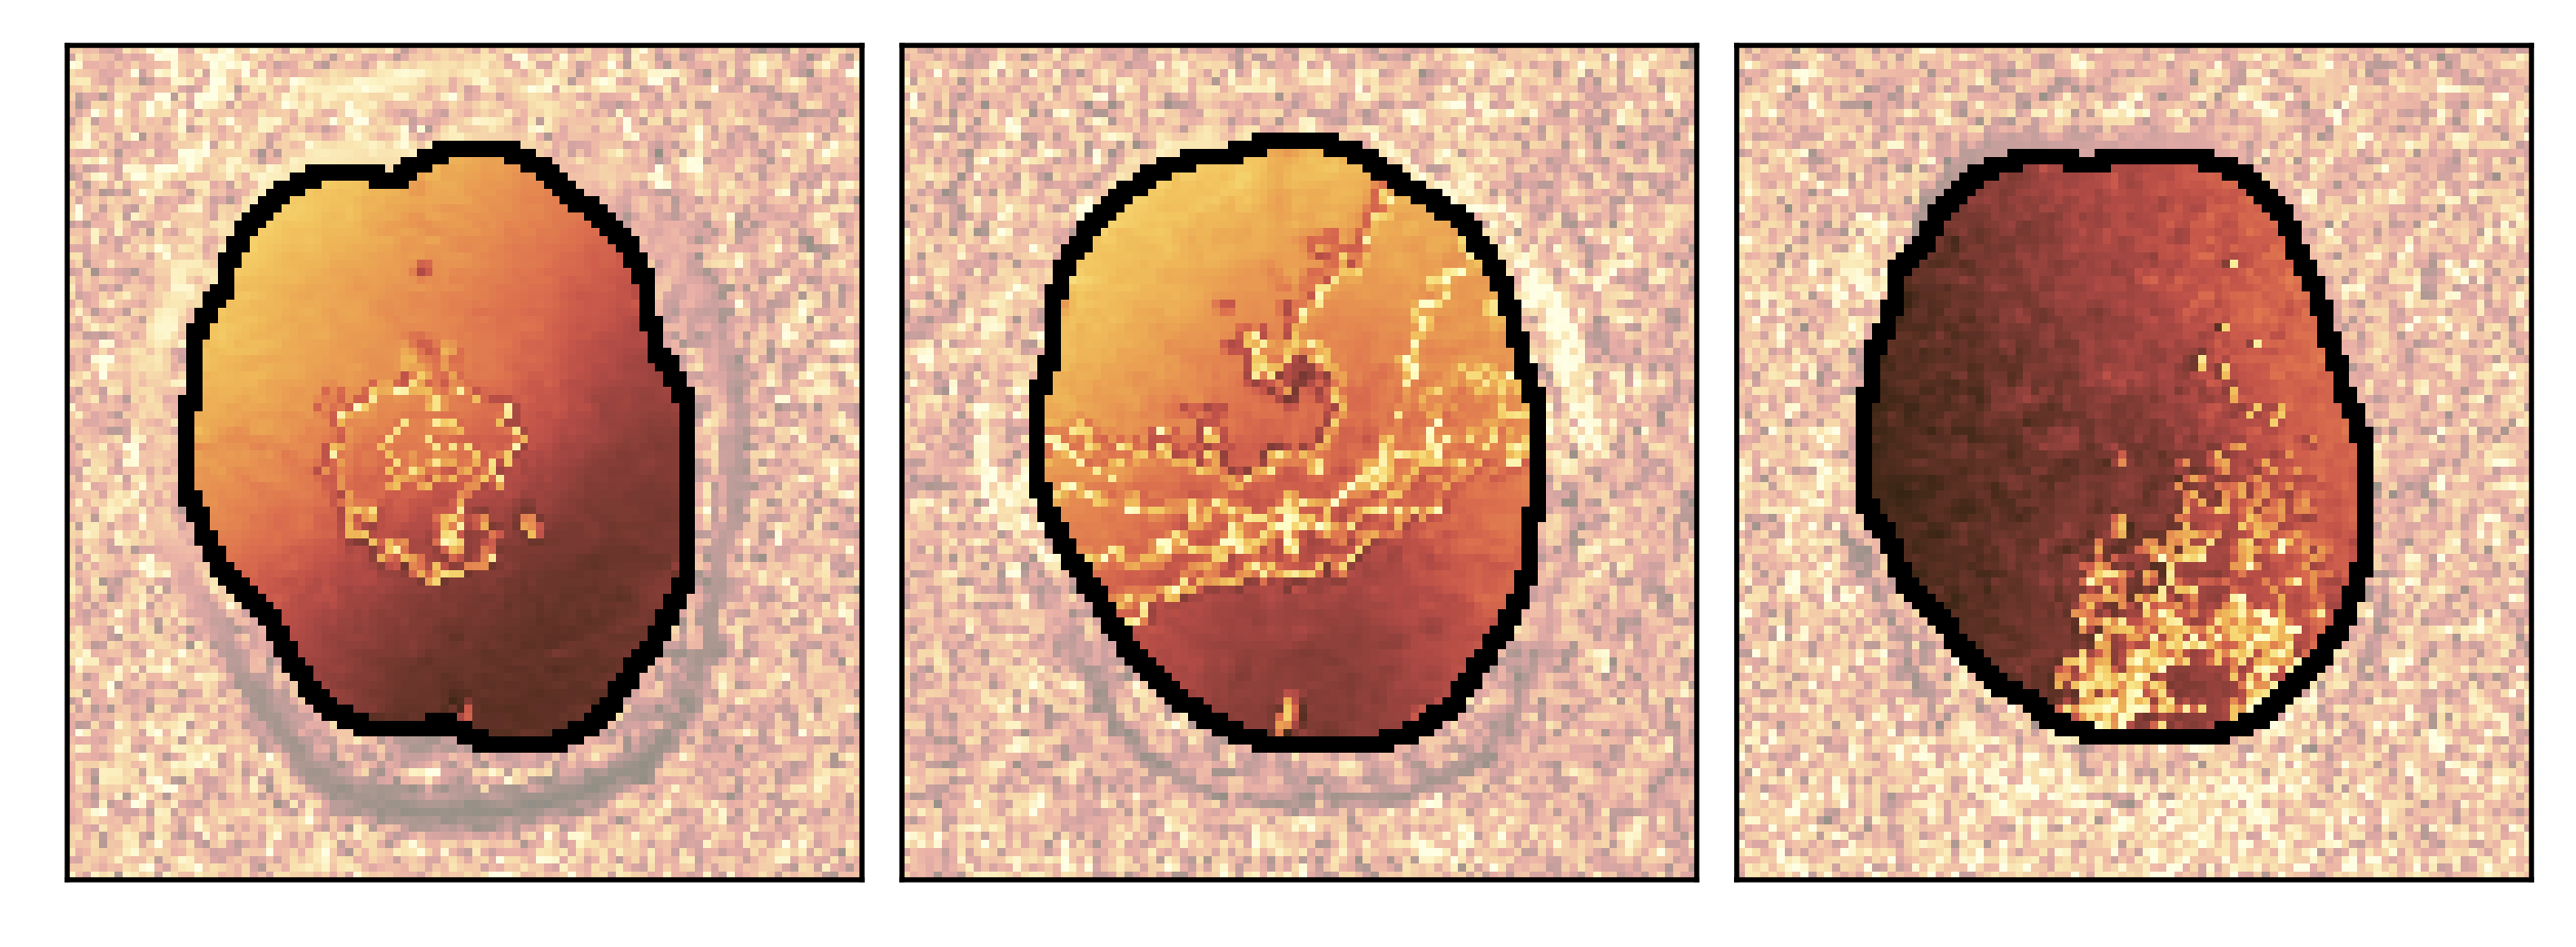

TD 4 Volunteer 9 sl 3


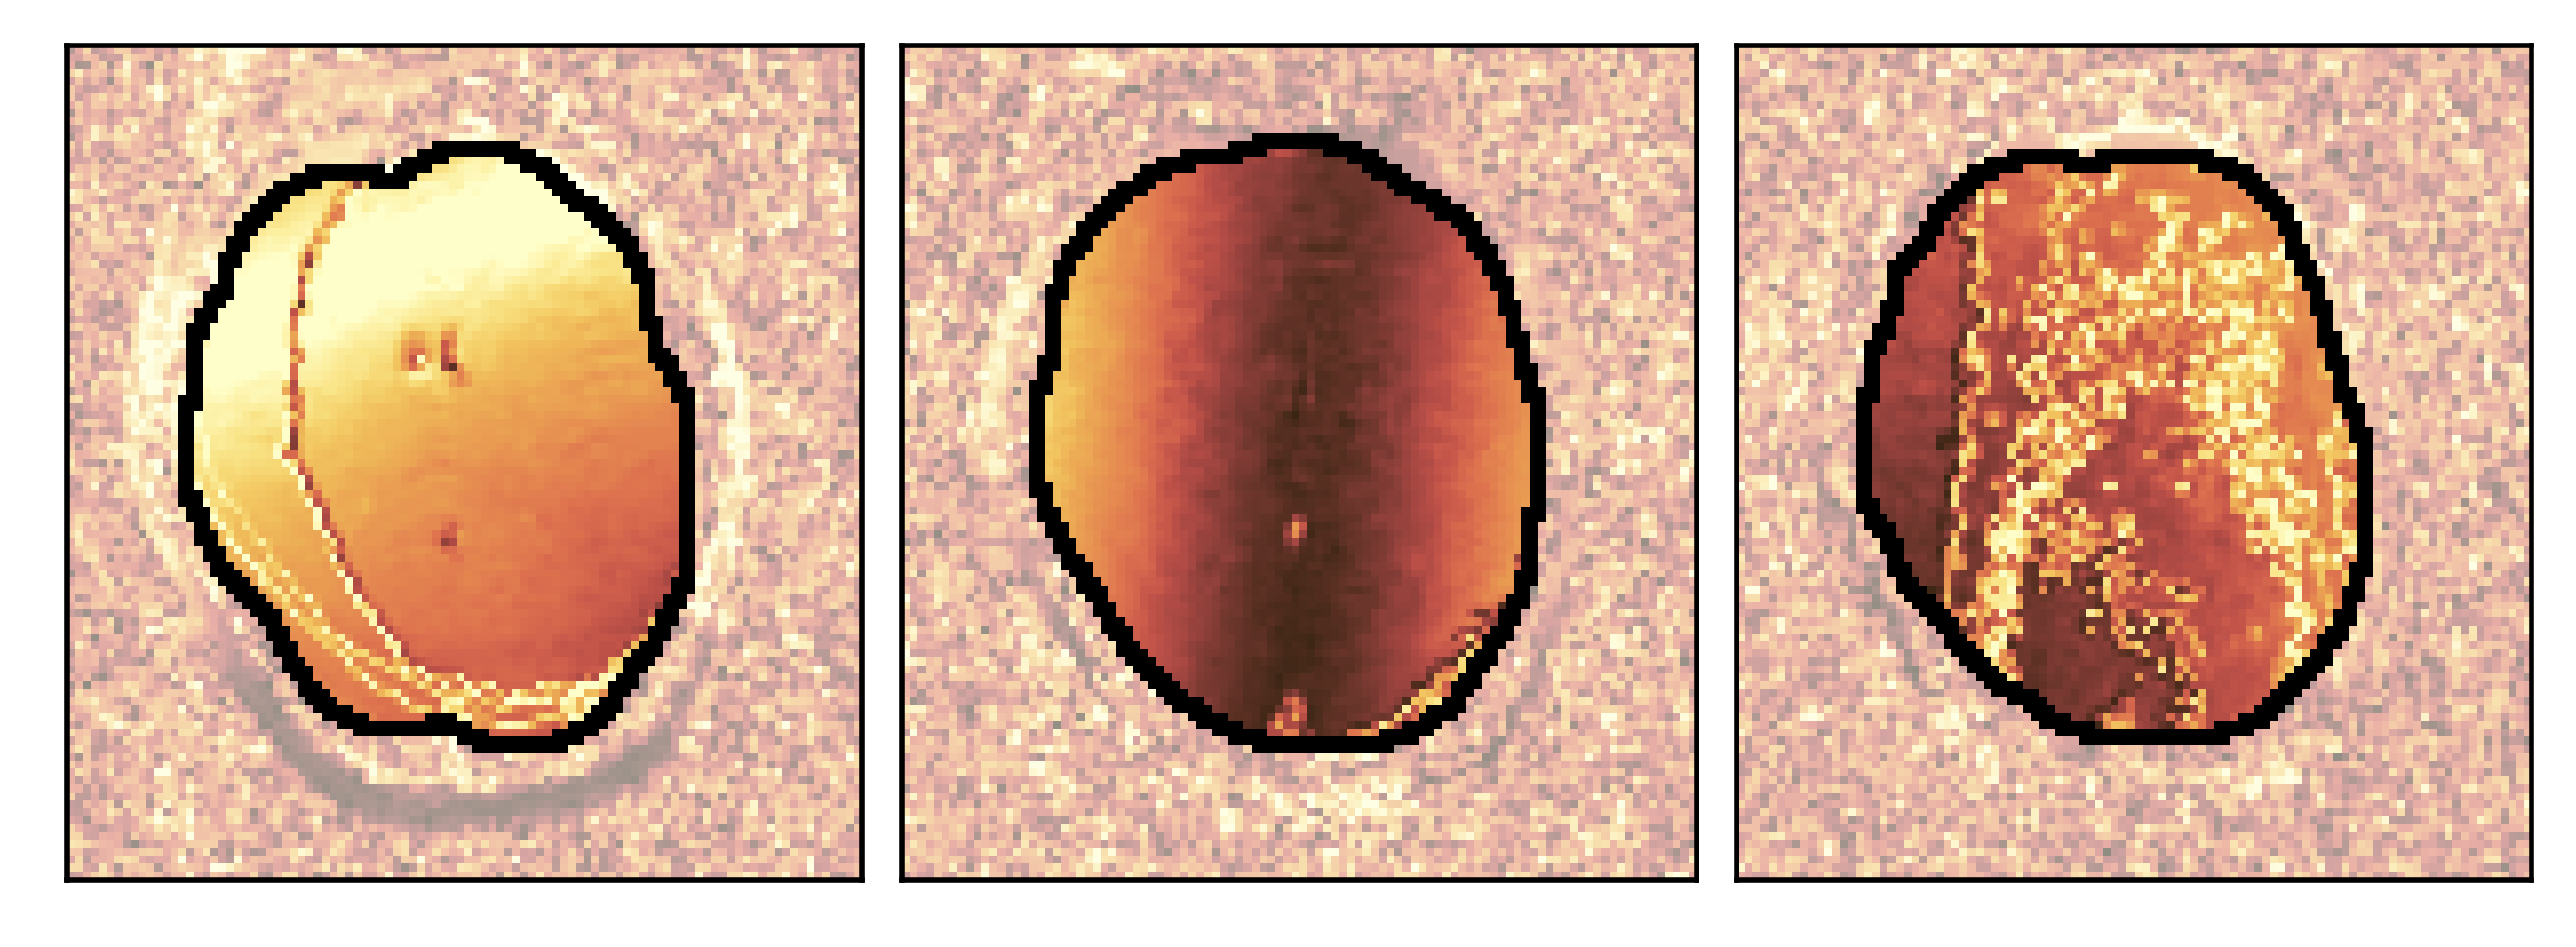

TD 7 Volunteer 9 sl 3


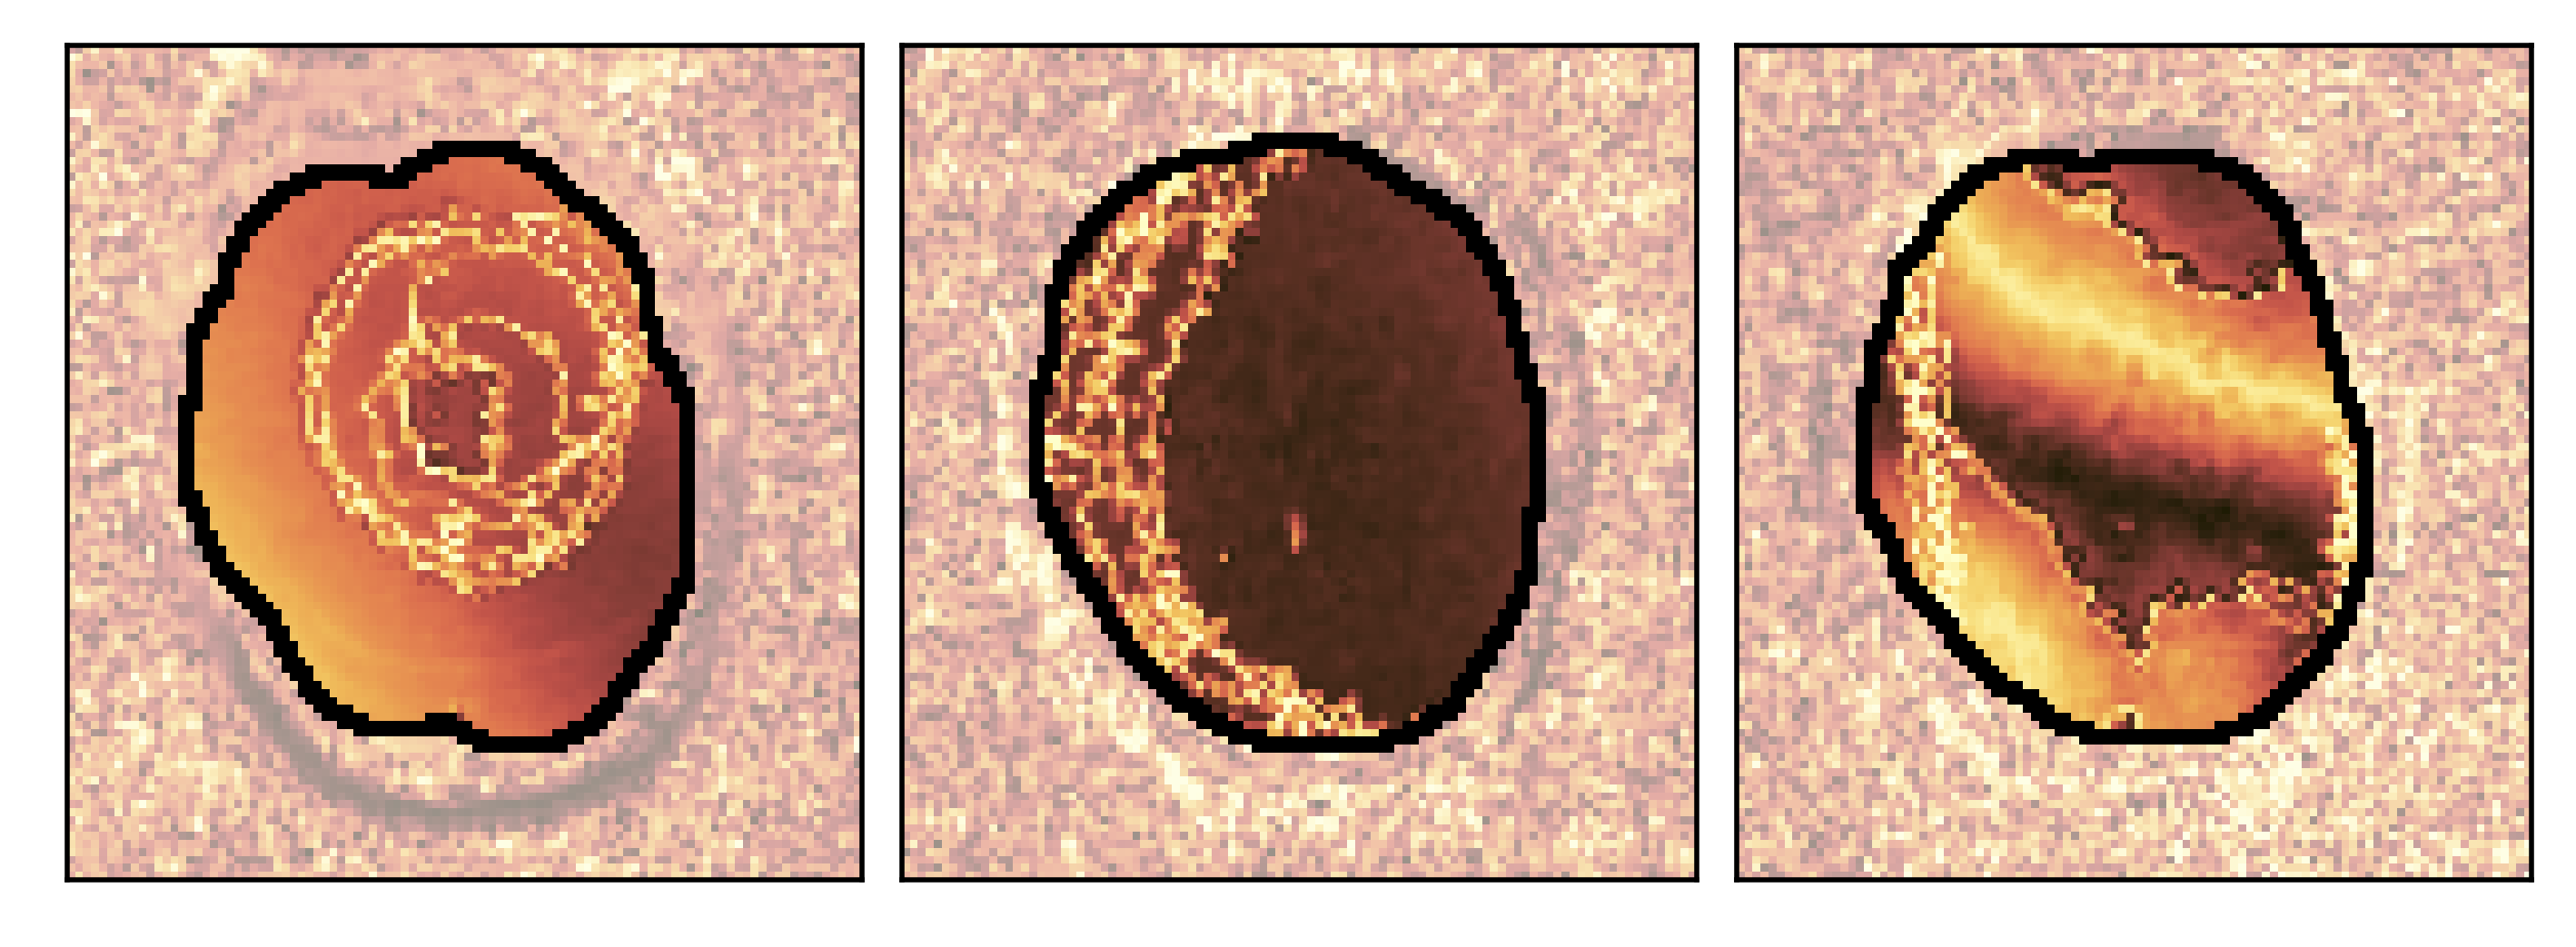

In [32]:
# Horizontal Fig 
for td in  [1,4,7]:
    print('TD',td, 'Volunteer',vv,'sl',sl)
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(7,5), dpi=500)

    w1 = 15
    w2 = 120
    l1= 15
    l2 = 115

    color = cm.lajolla_r
    ######### STandard Deviation 
    phs_m0 = (M0_std) #* M0_mask[:,:,:,diffusion,0,:]
    phs_m1 = (M1_std) #* M1_mask[:,:,:,diffusion,0,:]
    phs_m2 = (M2_std) #* M2_mask[:,:,:,diffusion,0,:] 
    axes[0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap =color,alpha = 0.5,interpolation = 'nearest')
    axes[1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,td,],vmin = 0,vmax = math.pi/2,cmap = color,alpha = 0.5,interpolation = 'nearest')
    im2=axes[2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap = color,alpha = 0.5,interpolation = 'nearest')

    phs_m0 = (M0_std[:,:,:,:,np.newaxis,:]) * M0_mask
    phs_m1 = (M1_std[:,:,:,:,np.newaxis,:]) * M1_mask
    phs_m2 = (M2_std[:,:,:,:,np.newaxis,:]) * M2_mask
    axes[0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    axes[1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    im4=axes[2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    axes[0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')


    for m in range(2):
        for j in range(3):
            axes[j].get_xaxis().set_ticks([])
            axes[j].get_yaxis().set_ticks([])

    plt.subplots_adjust(wspace=0.05, hspace=0.03)   
    plt.show()

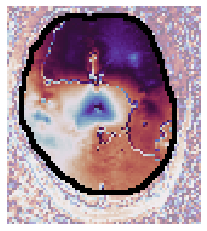

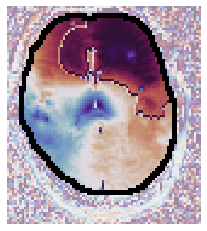

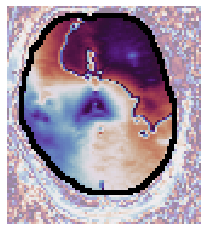

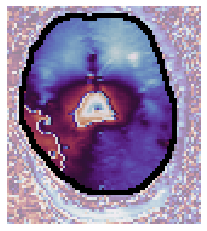

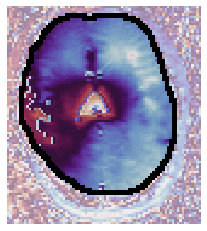

In [33]:
# Horizontal Fig 
td = 0
w1 = 25
w2 = 115
l1= 25
l2 = 105
for ii in range(5):
    color = 'twilight'
    phs_m2 = np.angle((M0_adj))
    plt.imshow(np.zeros((128,128)),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')

    plt.imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,ii,td],vmin = -math.pi,vmax = math.pi,cmap = color,alpha = 0.5,interpolation = 'nearest')

    phs_m2 = np.angle((M0_adj)) * M2_mask

    plt.imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,ii,td],vmin = -math.pi,vmax = math.pi,cmap = color,interpolation = 'nearest')
    plt.imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')

    plt.axis('off')
    plt.show()


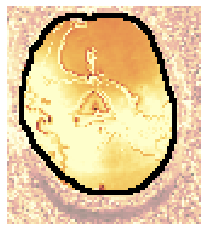

In [34]:


# Horizontal Fig 
td = 0
w1 = 25
w2 = 115
l1= 25
l2 = 105
for ii in range(1):
    color = cm.lajolla_r
    phs_m2 = M0_std
    plt.imshow(np.zeros((128,128)),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')

    plt.imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap = color,alpha = 0.5,interpolation = 'nearest')

    phs_m2 = M0_std[:,:,:,:,np.newaxis,:] * M0_mask

    plt.imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,ii,td],vmin =0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    plt.imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')

    plt.axis('off')
    plt.show()


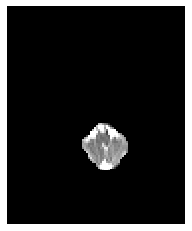

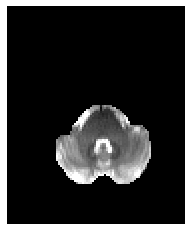

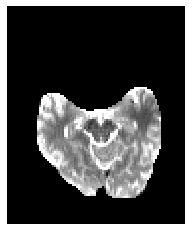

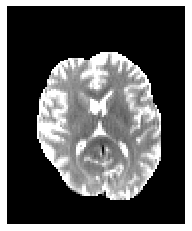

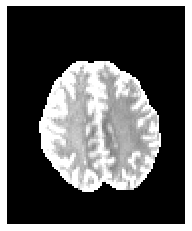

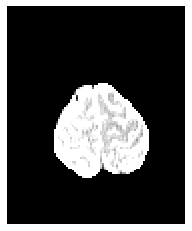

In [35]:
w1 = 5
w2 = 115
l1= 15
l2 = 105


for ii in range(6):
    plt.imshow(np.zeros((w2-w1,l2-l1)),vmin = 0,vmax = 1,cmap = 'gray',interpolation = 'nearest')
    plt.imshow(M0_mag[w1:w2,l1:l2,ii,0,0,0]*M0_mask[w1:w2,l1:l2,ii,0,0,0],cmap = 'gray',vmin = 0, vmax = 800,interpolation = 'nearest')
    plt.axis('off')
    plt.show()
